In [1]:
import os

import time

import numpy as np
import pandas as pd
from scipy.stats import reciprocal

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV

#Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Artificial Neural Networks

L'introduzione delle reti neurali artificiali e' datata al 1943, anno in cui McCulloch e Pitts presentano il primo modello computazionale ispirato al neurone.<br>
Attualmente hanno guadagnato notevole interesse per diversi motivi contigenti:
- enormi quantita' di dati per l'addestramento
- aumento della capacita' computazionale per supportare il training di grandi ANN. Da sottolineare il contributo dall'industria del gaming con l'introduzione di GPU - graphical processing unit - e lo sviluppo di architetture ad hoc come TPU, FPGA o chip neuromorfici.
- progressi negli algoritmi di apprendimento ed ottimizzazione

Il perceptron e' la piu' semplice architettura ANN ed e' basato su una singola linear threshold unit - LTU.
$$y_{\mathbf{w}}(\mathbf{x}) = \phi(\mathbf{w}^T\mathbf{x})$$
dove $\phi$ puo' essere una funzione di Heaviside oppure una funzione segno:
$$ hs(x) = 
\begin{cases}
    0 & \text{se } x<0\\
    1 & \text{se} x \geq 0
\end{cases}
\hspace{1cm}
sgn(x) = 
\begin{cases}
    -1 & \text{se } x<0\\
    0 & \text{se} x == 0\\
    1 & \text{se} x\geq 0
\end{cases}
$$

In general un perceptron puo' essere composto da una sequenza di LTU - **layer** - dove ogni LTU di un layer e' connessa ad ogni LTU del layer precedente. In questo caso si parla di **fully connected** o **dense layer**. 

![](perceptron_layer.png)

Nella figura vediamo come il bias venga inserito nell'**input layer** come unita' con valore 1.

E' possibile formulare la seguente architettura in termini matriciali, considerando l'intera feature matrix o matrice delle istanze $\mathbf{X}$:
$$y_{\mathbf{W,b}}(\mathbf{X}) = \phi(\mathbf{XW} + \mathbf{b})$$

dove $\phi$ indica una generica **activation function**.

La fase di learning del perceptron utilizza il gradiente discendente, il quale e' ispirato a *Hebbian learning* - la forza della connessione tra due neuroni aumenta quando uno dei due "innesca" o "stimola" il secondo. Nel caso del perceptron vengono rafforzati i pesi delle connessioni che riducono l'errore di predizione.

Sulla base dell'architettura del perceptron si possono creare architetture piu' complesse "impilando" diversi layer densi; definendo quindi un **Multilayer Perceptron - MLP**.

![](mlp.png)

L'elemento caratterizzante questa architettura e' la presenza di 1 o piu' livelli nascosti - **hidden layers**. Ogni hidden layer include anche un'unita di bias.<br>
Quando gli hidden layer sono molti si parla di architettura **deep neural network - DNN**. 

L'utilizzo di un'architettura deep e' resa computazionalmente ammissibile dall'algoritmo di backpropagation (1986) che permette di aggiornare i pesi di tutti i livelli mediante due scansioni della rete: una forward e una backward secondo un approccio di tipo Gradient Descent.

Rispetto alla LTU del perceptron viene introdotta un'ulteriore modifica per evitare che il gradiente venga posto a 0 - heaviside e sgn hanno gradiente 0. Le alternative per definire la funzione di attivazione $\phi$ sono molteplici, tuttavia in pratica vengono utilizzate prevalentemente 3 funzioni:
- sigmoid: $\phi(x) = 1 / (1 + exp(-x))$
- hyperbolic tangent: $\phi(x) = tanh(x)$
- ReLU - Rectified Linear Unit: $\phi(x) = max(0,x)$. Non e' differenziabile in 0 ma e' diventata lo standard de facto per performance e facilita' di computazione.

Le activation function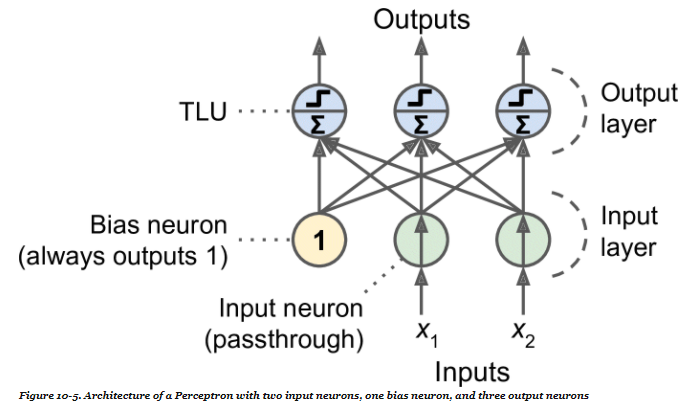 sono fondamentali nelle architetture DNN perche' introducono la non-linearita'; senza activation function non lineari la composizione dei layer restituirebbe una funzione lineare in quanto ogni layer e' una funzione lineare $\mathbf{w}^T\mathbf{x}$.

### MLP for Regression
Per applicare MLP ad un problema di regressione necessitiamo di una singola unita' di output che restituisce un valore reale, il valore predetto. E' possibile aggiungere altre unita' di output di tipo reale in caso di regressione multivariata - predico piu' valori associati ad una nuova istanza. <br>
Nel caso di regressione l'activation function non e' necessaria tuttavia, posso utilizzare alcune funzioni se voglio garantire alcune condizioni sull'output:
- output positivo: ReLU, softplus $\phi(x)=log(1+exp(x))$
- insieme limitato: logistic o $tanh$
Come loss function si possono utilizzare MSE - mean squared error, MAE - mean absolute error oppure Huber loss.

### MLP for Classification
Per un problema di classificazione binaria e' necessaria una sola unita' di output tra 0 e 1 - probabilita' della classe positiva. Per gestire un problema di multiclass classification viene inserita un'unita' di output per ogni classe a cui applicare una funzione di attivazione softmax. Se $\mathbf{s}(\mathbf{x})$ e' il vettore che in posizione $k$ contiene lo score assegnato alla classe $k$, cioe' output della $k$-esima unita' di output, la softmax function di $\mathbf{s}_k(\mathbf{x})$ e' data da:
$$\sigma(\mathbf{s}(\mathbf{x})_k))=\frac{exp(\mathbf{s}_k(\mathbf{x}))}{\sum_{j=1}^K exp(\mathbf{s}_j(\mathbf{x}))}$$
e la classe predetta corrisonde al valore di $k$ con softmax function piu' elevata.<br>
Come loss function si utilizza la cross-entropy loss

![](categorical_cross_entropy.jpg)

## Implementing MLPs with Keras
Keras (https://keras.io/) e' un API di alto livello per il deep learning che permette di definire, addestrare e valutare qualsiasi architettura di tipo ANN.

Keras si basa su un backend per la computazione che puo' essere TensorFlow, CNTK o Theano. Tuttavia, TensorFlow viene rilasciato con un'implementazione di Keras a cui si aggiungono delle funzionalita' extra.

In questo notebook utilizzeremo l'implementazione delle API di Keras rilasciata in TensorFlow.

In [ ]:
! pip install tensorflow

In [2]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [3]:
from tensorflow import keras

Come esempio applicativo utilizziamo un dataset simile al MNIST, ma relativo ad immagini di capi di abbigliamento a cui e' stata assegnata una label indicante il tipo di capo. Affrontiamo quindi un problema di classificazione multiclasse.

In [4]:
(X_train_full, y_train_full),(X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Su questo dataset, estraiamo un validation set dal training set e rilascaliamo le immagini.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [7]:
X_train.shape, X_valid.shape

((55000, 28, 28), (5000, 28, 28))

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

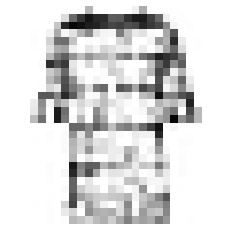

'T-shirt/top'

In [10]:
plt.imshow(X_train[10], cmap="binary")
plt.axis('off')
plt.show()
class_names[y_train[10]]

### Creazione del modello MLP

![](mlp_multiclass.jpg)

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Abbiamo creato un modello di tipo **Sequential** - uno dei piu' semplici - in cui i livelli sono messi in sequenza. Stiamo quindi impilando gli hidden layer secondo l'architettura MLP. Il primo livello - quello di input - e' modellato da un oggetto **Flatten** che converte l'input originario (matrice 28x28) in un vettore, linearizzando o flattenizzando la matrice dell'immagine. Attraverso il parametro **input_shape** specifico la dimensionalita' dell'input, cioe' il numero di feature di ogni istanza.

Viene aggiunto un hidden layer di tipo fully connected mediante la creazione di un oggetto **Dense**. Devo specificare quante unita' compongono il livello e quale funzione di attivazione utilizzare.

Dopo aver aggiunto un ulteriore hidden layer contenente 100 unita' e funzione di attivazione ReLU, viene aggiunto il livello di output. Dal momento che il numero di classi e' 10 e siamo in un contesto di multiclass classification posso utilizzare softmax come funzione di attivazione, in modo da ottenere un singolo input.

NB: Ogni livello gestisce la sua matrice dei pesi $\mathbf{W}$ e il vettore dei bias $\mathbf{b}$. Tali elementi possono essere ottenuti mediante il metodo **get_weights**

In [15]:
model.layers[0]

In [22]:
W_h1, b_h1 = model.layers[1].get_weights()

In [23]:
W_h1, W_h1.shape, b_h1, b_h1.shape

(array([[-0.01240351,  0.02237245, -0.03713624, ..., -0.03133539,
          0.00477104, -0.04797988],
        [-0.05552161, -0.01121103,  0.05793011, ..., -0.03282716,
          0.03758842, -0.01155985],
        [-0.05469371, -0.03696592,  0.04331162, ...,  0.06354666,
         -0.02071717,  0.0489953 ],
        ...,
        [-0.04948395,  0.0630403 , -0.01909962, ...,  0.01168671,
          0.0014462 , -0.00078992],
        [-0.04287574,  0.03493588, -0.03017796, ..., -0.0391106 ,
          0.04767261,  0.02697351],
        [ 0.06037787, -0.05717377,  0.02636849, ...,  0.01327251,
          0.05017839,  0.0498945 ]], dtype=float32),
 (784, 300),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0

La matrice dei pesi di ogni layer viene inizializzata in modo casuale, mentre il vettore dei bias viene inizializzato con 0. E' possibile modificare questo comportamento tramite gli argomenti **set_kernel_initializer** e **bias_initializer**.


Il metodo **summary** visualizza tutti i livelli del modello e fornisce alcune informazioni sulla dimensione dei livelli e il numero di parametri del modello. Mentre l'attributo **layers** permettere di accedere ad un singolo livello.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Il modello ha 266,610 parametri, e' flessibile ma incline all'overfitting. Abbiamo bisogno di avere molti dati di training.

### Compilazione del modello
Dopo la creazione di un modello devo specificare la funzione di loss e l'algoritmo di ottimizzazione, ed eventualmente le metriche di performance da utilizzare. Il metodo **compile** viene invocato per questi scopi

In [26]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy'],
             )

### Training
Il training del modello avviene invocando il metodo **fit**. Richiede il training set e il relativo label vector, il numero di epoche (quante volte devo scansionare tutto il training set). Posso passare anche un validation set in modo da verificare come il modello si comporta su dati "nuovi" attraverso l'argomento **validation_data**.

Per definire un validation set posso utilizzare il parametro **validation_split** che indica la percentuale di istanze da inserire nel validation set. 

Nel caso la distribuzione delle classi non sia bilanciata possiamo applicare un vettore di pesi alle classi in modo da dare piu' peso alle classi sottorappresentate.

In [32]:
print(X_train.shape, X_valid.shape)
history = model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_valid,y_valid),
          batch_size = 64
         )

(55000, 28, 28) (5000, 28, 28)
Epoch 1/5
860/860 [==============================] - 2s 2ms/step - loss: 0.1531 - accuracy: 0.9469 - val_loss: 0.2971 - val_accuracy: 0.8920
Epoch 2/5
860/860 [==============================] - 2s 3ms/step - loss: 0.1516 - accuracy: 0.9469 - val_loss: 0.3784 - val_accuracy: 0.8698
Epoch 3/5
860/860 [==============================] - 2s 2ms/step - loss: 0.1493 - accuracy: 0.9485 - val_loss: 0.3889 - val_accuracy: 0.8650
Epoch 4/5
860/860 [==============================] - 2s 2ms/step - loss: 0.1483 - accuracy: 0.9483 - val_loss: 0.2925 - val_accuracy: 0.8982
Epoch 5/5
860/860 [==============================] - 2s 2ms/step - loss: 0.1476 - accuracy: 0.9482 - val_loss: 0.3930 - val_accuracy: 0.8658


L'oggetto **History** restituito dal metodo fit contiene i parametri di training (**.params**), la lista delle epoche (**.epoch**) e un dict con i valori della loss function e delle metriche di performance sul training e validation set per ogni epoca.

In [33]:
history.params, history.epoch

({'verbose': 1, 'epochs': 5, 'steps': 860}, [0, 1, 2, 3, 4])

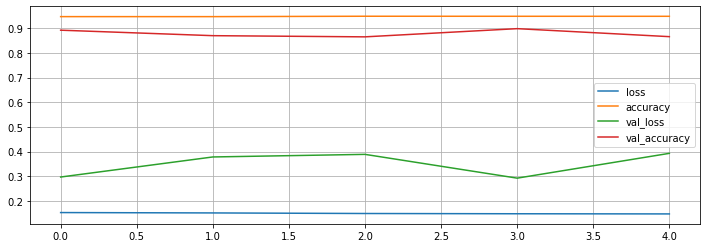

In [34]:
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

Osserviamo un po' di overfitting.

Nel caso venga invocato nuovamente il metodo fit, senza ricreare il modello, il processo di training riprende dall'ultimo stato dei parametri.

Per valutare il modello appresso sul test set utilizziamo il metodo **evaluate**.

In [35]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 73.3025 - accuracy: 0.8554


[73.30248260498047, 0.855400025844574]

Mediante il metodo **predict** eseguiamo una predizione circa una nuova istanza.

In [38]:
model.predict(X_test[:3])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Se invece voglio ottenere la classe predetta, si utilizza il metodo **predict_classes**.  

Visto che il metodo è deprecato, seguiamo il consiglio del warning:

In [39]:
np.array(class_names)[np.argmax(model.predict(X_test[:3]),axis=-1)]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

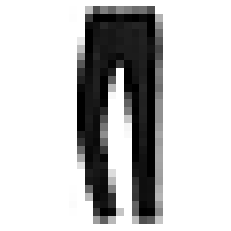

'Trouser'

In [42]:
plt.imshow(X_test[2], cmap="binary")
plt.axis('off')
plt.show()
class_names[y_test[2]]

## Regression by Sequential API
Affrontiamo un problema di regressione utilizzando un'architettura simile.

Utilizziamo un dataset in cui siamo interessati a predirre il prezzo di real estate in California

In [7]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [45]:
X_train.dtype

dtype('float64')

La differenza principale con l'architettura precedente è la presenza di una singola unità di output che non utilizza una funzione di attivazione. Come loss function utilizziamo MSE - mean squared error.

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/30


C:\Users\matte\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


363/363 [==============================] - 1s 1ms/step - loss: 1.6624 - val_loss: 3.2248
Epoch 2/30
363/363 [==============================] - 0s 964us/step - loss: 0.8124 - val_loss: 0.9569
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.7093 - val_loss: 0.6677
Epoch 4/30
363/363 [==============================] - 0s 964us/step - loss: 0.6633 - val_loss: 0.6202
Epoch 5/30
363/363 [==============================] - 0s 981us/step - loss: 0.6280 - val_loss: 0.5880
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6008 - val_loss: 0.5632
Epoch 7/30
363/363 [==============================] - 0s 948us/step - loss: 0.5776 - val_loss: 0.5416
Epoch 8/30
363/363 [==============================] - 0s 978us/step - loss: 0.5584 - val_loss: 0.5234
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5422 - val_loss: 0.5078
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5273 - val_loss: 0.4938


In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                270       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [49]:
X_train.shape

(11610, 8)

In [51]:
y_pred

array([[0.5882781],
       [1.5954754],
       [3.3153524]], dtype=float32)

## Complex Models - Functional API
Per costruire modelli con topologie più complesse si utilizza **FunctionalAPI**. <br>
Si vuole definire un architettura di tipo *Wide and Deep* mostrata in figura:

![](wide_deep_1.png)

Una parte o tutto il layer di input è connesso direttamente con il layer di output e, allo stesso tempo, il layer di input o parte di esso è alla base di un'architettura MLP deep. In questo modo è possibile apprendere dei pattern più complessi e delle regole più semplici nello stesso momento.

![](mulp_multiin.jpg)

In [52]:
input_ = keras.layers.Input(shape=X_train.shape[1:]) # se house le unita' di inpot sono 8
hidden1 = keras.layers.Dense(30, activation="relu")(input_) 
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In primis, definiamo l'input layer specificando la dimensione di una singola istanza di input: **shape** e **dtype**. Poi definiamo un hidden layer denso passando il livello di input come argomento di una funzione. In questo modo definiamo una dipendenza funzionale tra hidden layer e input layer ed indichiamo a Keras che i due livelli devono essere connessi.<br>
L'elemento di novità è dato dal layer **concatenate**. Questo livello viene generato concatenando i livelli presi come argomento.

In [53]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)
print(mse_test, y_pred)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.5669 - val_loss: 0.7504
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6970 - val_loss: 0.6420
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6356 - val_loss: 0.5999
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5948 - val_loss: 0.6215
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5617 - val_loss: 0.5275
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5375 - val_loss: 0.5078
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5163 - val_loss: 0.5413
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4993 - val_loss: 0.4749
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.4769
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4723 - val_loss: 0.4821

E' anche possibile utilizzare una parte dell'input nel ramo *wide* e una parte di input - anche sovrapposta con la prima - nel ramo *deep*. Come mostrato in figura.

![](multi_in_mlp.png)

![](mlp_multiout.jpg)

Il precedente modello viene codificato nel seguente modo:

In [54]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

La seguente definizione impatta sugli argomenti dei metodo fit, evaluate e predict, dal momento che dobbiamo passare un numero di sottomatrici della feature matrix pari al numero di livelli di input definiti.

In [55]:
model.compile(loss="mse", 
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B),
                    y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
print(mse_test, y_pred)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.7735 - val_loss: 1.2059
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7667 - val_loss: 0.8119
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6848 - val_loss: 0.6839
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6356 - val_loss: 0.6081
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5994 - val_loss: 0.5592
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5698 - val_loss: 0.5275
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5448 - val_loss: 0.5012
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5234 - val_loss: 0.4817
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.4655
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4899 - val_loss: 0.4498

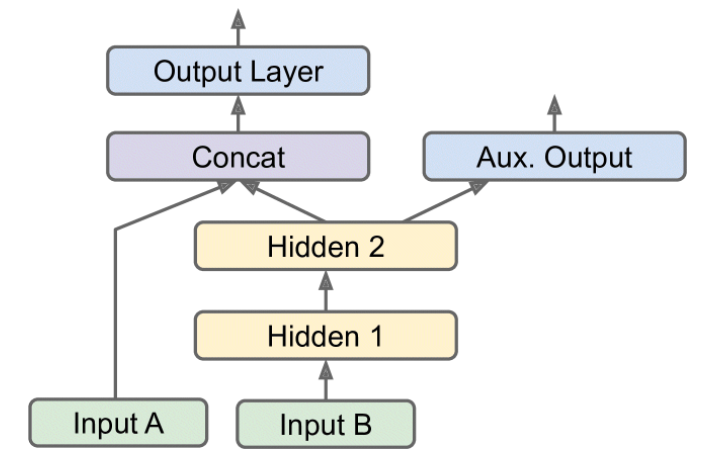E' possibile anche definire più output layers, nel caso di multitask classification oppure per inserire un fattore di regolarizzazione. La modalità di aggiunta di livelli di output multipli è analoga a quanto visto in precedenza. Per esempio se volessimo definire il modello mostrato in figura, in cui si applica una regolarizzazione sul ramo *deep*:

![](multi_out_mlp.png)

Otterremmo il seguente codice:

In [8]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output_1 = keras.layers.Dense(1, name="main_output")(concat)
output_2 = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output_1, output_2])

In [12]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

Ogni output layers richiede una specifica loss function.<br>
Posso priviligiare il contributo delle diverse loss function mediante il parametro **loss_weight** del metodo compile.

In [10]:
model.compile(loss=["mse", "mse"],
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

Anche in questo caso il numero di label vector passati deve essere uguale al numero di output layer.

In [13]:
history = model.fit([X_train_A, X_train_B],
                    [y_train, y_train],
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
                   )

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.7644 - main_output_loss: 2.4705 - aux_output_loss: 5.4096 - val_loss: 2.4349 - val_main_output_loss: 2.2279 - val_aux_output_loss: 4.2981
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 1.1219 - main_output_loss: 0.8196 - aux_output_loss: 3.8426 - val_loss: 0.9656 - val_main_output_loss: 0.7208 - val_aux_output_loss: 3.1692
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8817 - main_output_loss: 0.6595 - aux_output_loss: 2.8808 - val_loss: 0.7911 - val_main_output_loss: 0.6055 - val_aux_output_loss: 2.4608
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7844 - main_output_loss: 0.6162 - aux_output_loss: 2.2988 - val_loss: 0.7257 - val_main_output_loss: 0.5772 - val_aux_output_loss: 2.0621
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7290 - main_output_loss: 0.5927 - aux_output_loss: 1.9554 - val_loss

In [14]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(total_loss, main_loss, aux_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.4955 - main_output_loss: 0.4335 - aux_output_loss: 1.0541
0.49552810192108154 0.43346330523490906 1.054110050201416


## Saving and Loading a Model
Il metodo **save** di Model o di Sequential permette di salvare tutte le componenti di un modello: archiettura, parametri del modello per ogni layer, iperparametri e il metodo di ottimizzazione utilizzato. Il formato utilizzato è HDF5

In [15]:
model.save("multiin_multiout_test.h5")

Per caricare un modello utilizzo il metodo **load_model**

In [16]:
model = keras.models.load_model("multiin_multiout_test.h5")

Tuttavia nel caso il processo di training duri molte ore è possibile eseguire dei salvataggi intermedi specificando al momento fit degli oggetti di callback.

### Callbacks
Il metodo fit accetta un argomento **callbacks** tramite cui è possibile passare una lista di oggetti che Keras invoca i) all'inizio o alla fine del training, ii) all'inizio e/o alla fine di un epoca, o iii) all'inizio e/o alla fine di un batch.

In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("simple_mlp.h5", save_best_only=True)

L'oggetto **ModelCheckpoint** salva il modello nel file specificato alla fine di ogni epoca. Nello specifico il salvataggio avviene solo se all'epoca attuale le performance sul validation set sono migliori delle epoche precedenti. 

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("simple_mlp.h5") #carico il modello che best performance su validation set
mse_test = model.evaluate(X_test, y_test)
print(mse_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.7209 - val_loss: 1.2784
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7804 - val_loss: 0.7318
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6907 - val_loss: 0.6194
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6338 - val_loss: 0.5702
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5883 - val_loss: 0.5333
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5492 - val_loss: 0.5005
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5165 - val_loss: 0.4658
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4887 - val_loss: 0.4420
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4654 - val_loss: 0.4226
Epoch 10/10
162/162 [==============================] - 0s 739us/step - loss: 0.4353
0.43531545996665

E' possibile implementare, mediante callback, un meccanismo di early stopping, utilizzando la classe **EarlyStopping**. Il processo di training viene interrotto quando non si misurano miglioramenti della loss function sul validation set per un numero specificato di epoche - espresso dal parametro **patience**. L'early stopping viene utilizzato anche come metodo per ridurre l'overfitting.

In [20]:
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4335 - val_loss: 0.3998
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4228 - val_loss: 0.3996
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4155 - val_loss: 0.4114
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4092 - val_loss: 0.4117
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4041 - val_loss: 0.4212
Epoch 6/100
162/162 [==============================] - 0s 720us/step - loss: 0.4152


In [21]:
model_early = keras.models.load_model('simple_mlp.h5')

In [22]:
model_early.evaluate(X_valid,y_valid)

121/121 [==============================] - 0s 983us/step - loss: 0.3996


0.3995828926563263

## TensorBoard
TensorBoard è uno strumento di visualizzazione che permette di osservare le proprietà e le performance del modello definito e appreso in Keras/TensorFlow

Per poter utilizzare tale strumento si devono creare dei file binari di log - **event file** - che TB analizza e visualizza

Passo 1: Definire una directory che contiene i log per TB.

In [23]:
def get_run_logdir(root_dir):
    return os.path.join(root_dir, time.strftime("run_%Y_%m_%d-%H_%M_%S"))

In [24]:
logdir = get_run_logdir(os.path.join(os.curdir, "tb_logs"))
print(logdir)

.\tb_logs\run_2022_03_08-16_00_11


Keras fornisce una classe callback **TensorBoard** che si occupa della scrittura degli event file nella directory specificata. Nel caso la directory non esistesse, viene creata.

Ogni directory di log contiene due directory: una per il training set e una per il validation set, se utilizzato.

In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

logdir = get_run_logdir(os.path.join(os.curdir, "tb_logs"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.4026 - val_loss: 1.1263
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6978 - val_loss: 0.6227
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6268 - val_loss: 0.5955
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5793 - val_loss: 0.5479
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5425 - val_loss: 0.5392
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5144 - val_loss: 0.5109
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4919 - val_loss: 0.4743
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4739 - val_loss: 0.4521
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4592 - val_loss: 0.4280
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4471 - val_loss: 0.4201

Passo 2: Eseguire TensorBoard.

In Jupyter si deve caricare l'estensione tensorboard

In [27]:
%load_ext tensorboard
%tensorboard --logdir=./tb_logs --port=6006

## Tuning Hyperparameters
Nelle DNN il numero di iperparametri è elevato ed aumenta in modo proporzionale alla profondità dell'architettura.

E' in ogni caso possibile utilizzare gli strumenti di ricerca degli iperparametri migliori forniti da SKL. Mediante l'oggetto **KerasRegressor** o **KerasClassifier** è possibile costruire un wrapper del modello definito in Keras.

In [ ]:
! pip install scikeras[tensorflow]

In [30]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [36]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [43]:
keras_reg = KerasRegressor(build_model)

In [32]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


C:\Users\matte\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


363/363 [==============================] - 1s 1ms/step - loss: 1.3335 - val_loss: 12.7529
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6802 - val_loss: 2.6679
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5430 - val_loss: 0.6604
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4844 - val_loss: 0.4512
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4563 - val_loss: 0.4382
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4423 - val_loss: 0.4143
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4318 - val_loss: 0.4054
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4257 - val_loss: 0.3966
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4191 - val_loss: 0.3935
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4157 - val_loss: 0.3880


KerasRegressor(
	model=<function build_model at 0x000002A09C975430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [39]:
keras_reg.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [34]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 745us/step


Possiamo ora applicare un RandomizedSearchCV

In [44]:
param_distribs = {
    "model__n_hidden": [0, 1, 2, 3],
    "model__n_neurons": np.arange(1, 100),
    "optimizer__learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3, verbose = 2)
rnd_search_cv.fit(X_train, y_train, epochs=30,verbose = 0)

121/121 [==============================] - 0s 692us/step


RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(model=<function build_model at 0x000002A09C832670>),
                   n_iter=5,
                   param_distributions={'model__n_hidden': [0, 1, 2, 3],
                                        'model__n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'optimizer__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A0A00AED30>})

In [42]:
rnd_search_cv.best_params_, rnd_search_cv.best_score_

({'model__n_hidden': 3,
  'model__n_neurons': 50,
  'optimizer__learning_rate': 0.003756125236850719},
 0.75104935776905)